In [1]:
from functools import cached_property
from dataclasses import dataclass
from collections import defaultdict
import numpy as np
import pandas as pd
import hist as hi
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mplhep as mh
mh.style.use(mh.styles.CMS)

In [123]:
type(np.sign(1).item())

int

In [16]:
@dataclass(frozen=True, unsafe_hash=True)
class RPCDetId:
    name: str
    region: int
    sector: int | None
    station: int | None
    roll: str
    wheel: int | None
    layer: int | None
    disk: int | None
    ring: int | None
    channel: int | None

    @classmethod
    def from_barrel_name(cls, name):
        # TODO re
        # name='W-2_RB1in_S01_Backward'

        # 'W-2', 'RB1in', 'S01', 'Backward'
        wheel, station_str, sector, roll = name.split('_')
        # -2
        wheel = int(wheel[1:])
        # 1
        sector = int(sector[1:])
        # B
        roll = roll[0]

        # 1
        station = int(station_str[2])
        if station <= 2:
            layer = (station - 1) * 2 + 1
            if 'out' in station_str:
                layer += 1
        else:
            layer = 4 + (station - 2)
            roll += station_str[3:] ## There are suffix, +, -, ++, --, etc

        return cls(name=name, region=0,
            sector=sector,
            station=station,
            roll=roll,
            wheel=wheel,
            layer=layer,
            disk=None,
            ring=None,
            channel=None
        )
            
            
    @classmethod
    def from_endcap_name(cls, name):
        # name='RE-4_R2_CH19_B'
        # 'RE-4', 'R2', 'CH19', 'B'
        signed_disk, ring, channel, roll = name.split('_')
        signed_disk = int(signed_disk[2:])
        ring = int(ring[1:])
        channel = int(channel[2:])
        disk = abs(signed_disk)
        region = np.sign(signed_disk)
        
        return cls(
            name=name,
            region=region,
            sector=None,
            station=None,
            roll=roll,
            wheel=None,
            layer=None,
            disk=disk,
            ring=ring,
            channel=channel
        )
    
    @classmethod
    def from_name(cls, name):
        if name.startswith("W"):
            return cls.from_barrel_name(name)
        else:
            return cls.from_endcap_name(name)

    @property
    def barrel(self) -> bool:
        return self.region == 0

    @property
    def endcap(self):
        return abs(self.region) == 1

    @property
    def irpc(self):
        return self.endcap and self.disk in (3, 4) and self.ring == 1

    @cached_property
    def key(self) -> str:
        if self.barrel:
            key = '_'.join(self.name.split('_')[1:2])
            key = key.strip('+-')
        else:
            key = f'RE{self.region * self.disk:+d}'
        return key

In [184]:
@dataclass
class RPCRoll:
    id: RPCDetId
    x: np.ndarray
    y: np.ndarray
    z: np.ndarray
    area: float
    
    @classmethod
    def from_row(cls, row):
        det_id = RPCDetId.from_name(row['roll'])
        x = row[[f'x{idx}' for idx in range(1, 5)]].to_numpy(np.float64)
        y = row[[f'y{idx}' for idx in range(1, 5)]].to_numpy(np.float64)
        z = row[[f'z{idx}' for idx in range(1, 5)]].to_numpy(np.float64)
        area = row['Area']
        
        return cls(det_id, x, y, z, area)
    
    @property
    def phi(self):
        phi = np.arctan2(self.y, self.x)
        phi[phi < 0] += 2 * np.pi
        if abs(phi[0] - phi[2]) > np.pi:
            phi[phi > np.pi] -= 2 * np.pi
        return phi

    @property
    def phi_deg(self):
        return np.rad2deg(self.phi)
    
    
    @property
    def polygon(self):
        if self.id.barrel:
            xy = np.stack([self.z, self.phi_deg], axis=1)
        else:
            xy = np.stack([self.x, self.y], axis=1)
        return Polygon(xy, closed=True)

In [185]:
@dataclass
class RPCShapes:
    h2_by_wheel_disk: dict[str, list[RPCRoll]]
    
    @classmethod
    def from_csv(cls, path):
        df = pd.read_csv(path)

        h2_by_wheel_disk = defaultdict(list)
        for _, row in df.iterrows():
            unit = RPCRoll.from_row(row)
            h2_by_wheel_disk[unit.id.key].append(unit)
        return cls(dict(h2_by_wheel_disk))
    
    def __getitem__(self, key: str) -> list[RPCRoll]:
        return self.h2_by_wheel_disk[key]
    
    def keys(self):
        return self.h2_by_wheel_disk.keys()

In [216]:
df_geom = pd.read_csv('./geom.csv')
df_eff = pd.read_csv('./efficiency.csv', index_col=0)

In [186]:
rpc = RPCShapes.from_csv('./geom.csv')

In [187]:

eff_data = {row['roll']: row['efficiency'] for _, row in df_eff.iterrows()}

In [196]:
df = pd.read_csv('./geom.csv')

In [198]:
type(next(df.iterrows())[1])

In [199]:
pd.Series

pandas.core.series.Series

In [210]:
def draw_geom(patches,
              values,
              xlabel=None,
              ylabel=None,
              zlabel=None,
              cmap='magma',
              edgecolor='gray',
              vmin=None,
              vmax=None,
              use_colorbar: bool = True,
              ax=None
):
    vmin = vmin or min(values)
    vmax = vmax or max(values)
    ax = ax or plt.gca()

    cmap = plt.get_cmap(cmap)

    collection = PatchCollection(patches)
    collection.set_color(cmap(values))
    collection.set_edgecolor(edgecolor)
    ax.add_collection(collection)

    # add colobar
    ax.autoscale_view()
    scalar_mappable = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(vmin=vmin, vmax=vmax) # FIXME
    )
    scalar_mappable.set_array([])
    axes_divider = make_axes_locatable(ax)
    cax = axes_divider.append_axes("right", size="5%", pad=0.2)
    colobar = fig.colorbar(scalar_mappable, cax=cax, pad=0.1)
    cax.set_ylabel(zlabel)

    # layout
    ax.set_aspect('equal')
    #fig.tight_layout()

    # grid
    ax.set_axisbelow(True)
    ax.grid()

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    #ax.set_xticks([-600, -400, -200, 0, 200, 400, 600])
    #ax.set_yticks([-600, -400, -200, 0, 200, 400, 600])

    mh.cms.label(ax=ax, year=2023, com=13.6, llabel='Preliminary', lumi=10)
    return fig

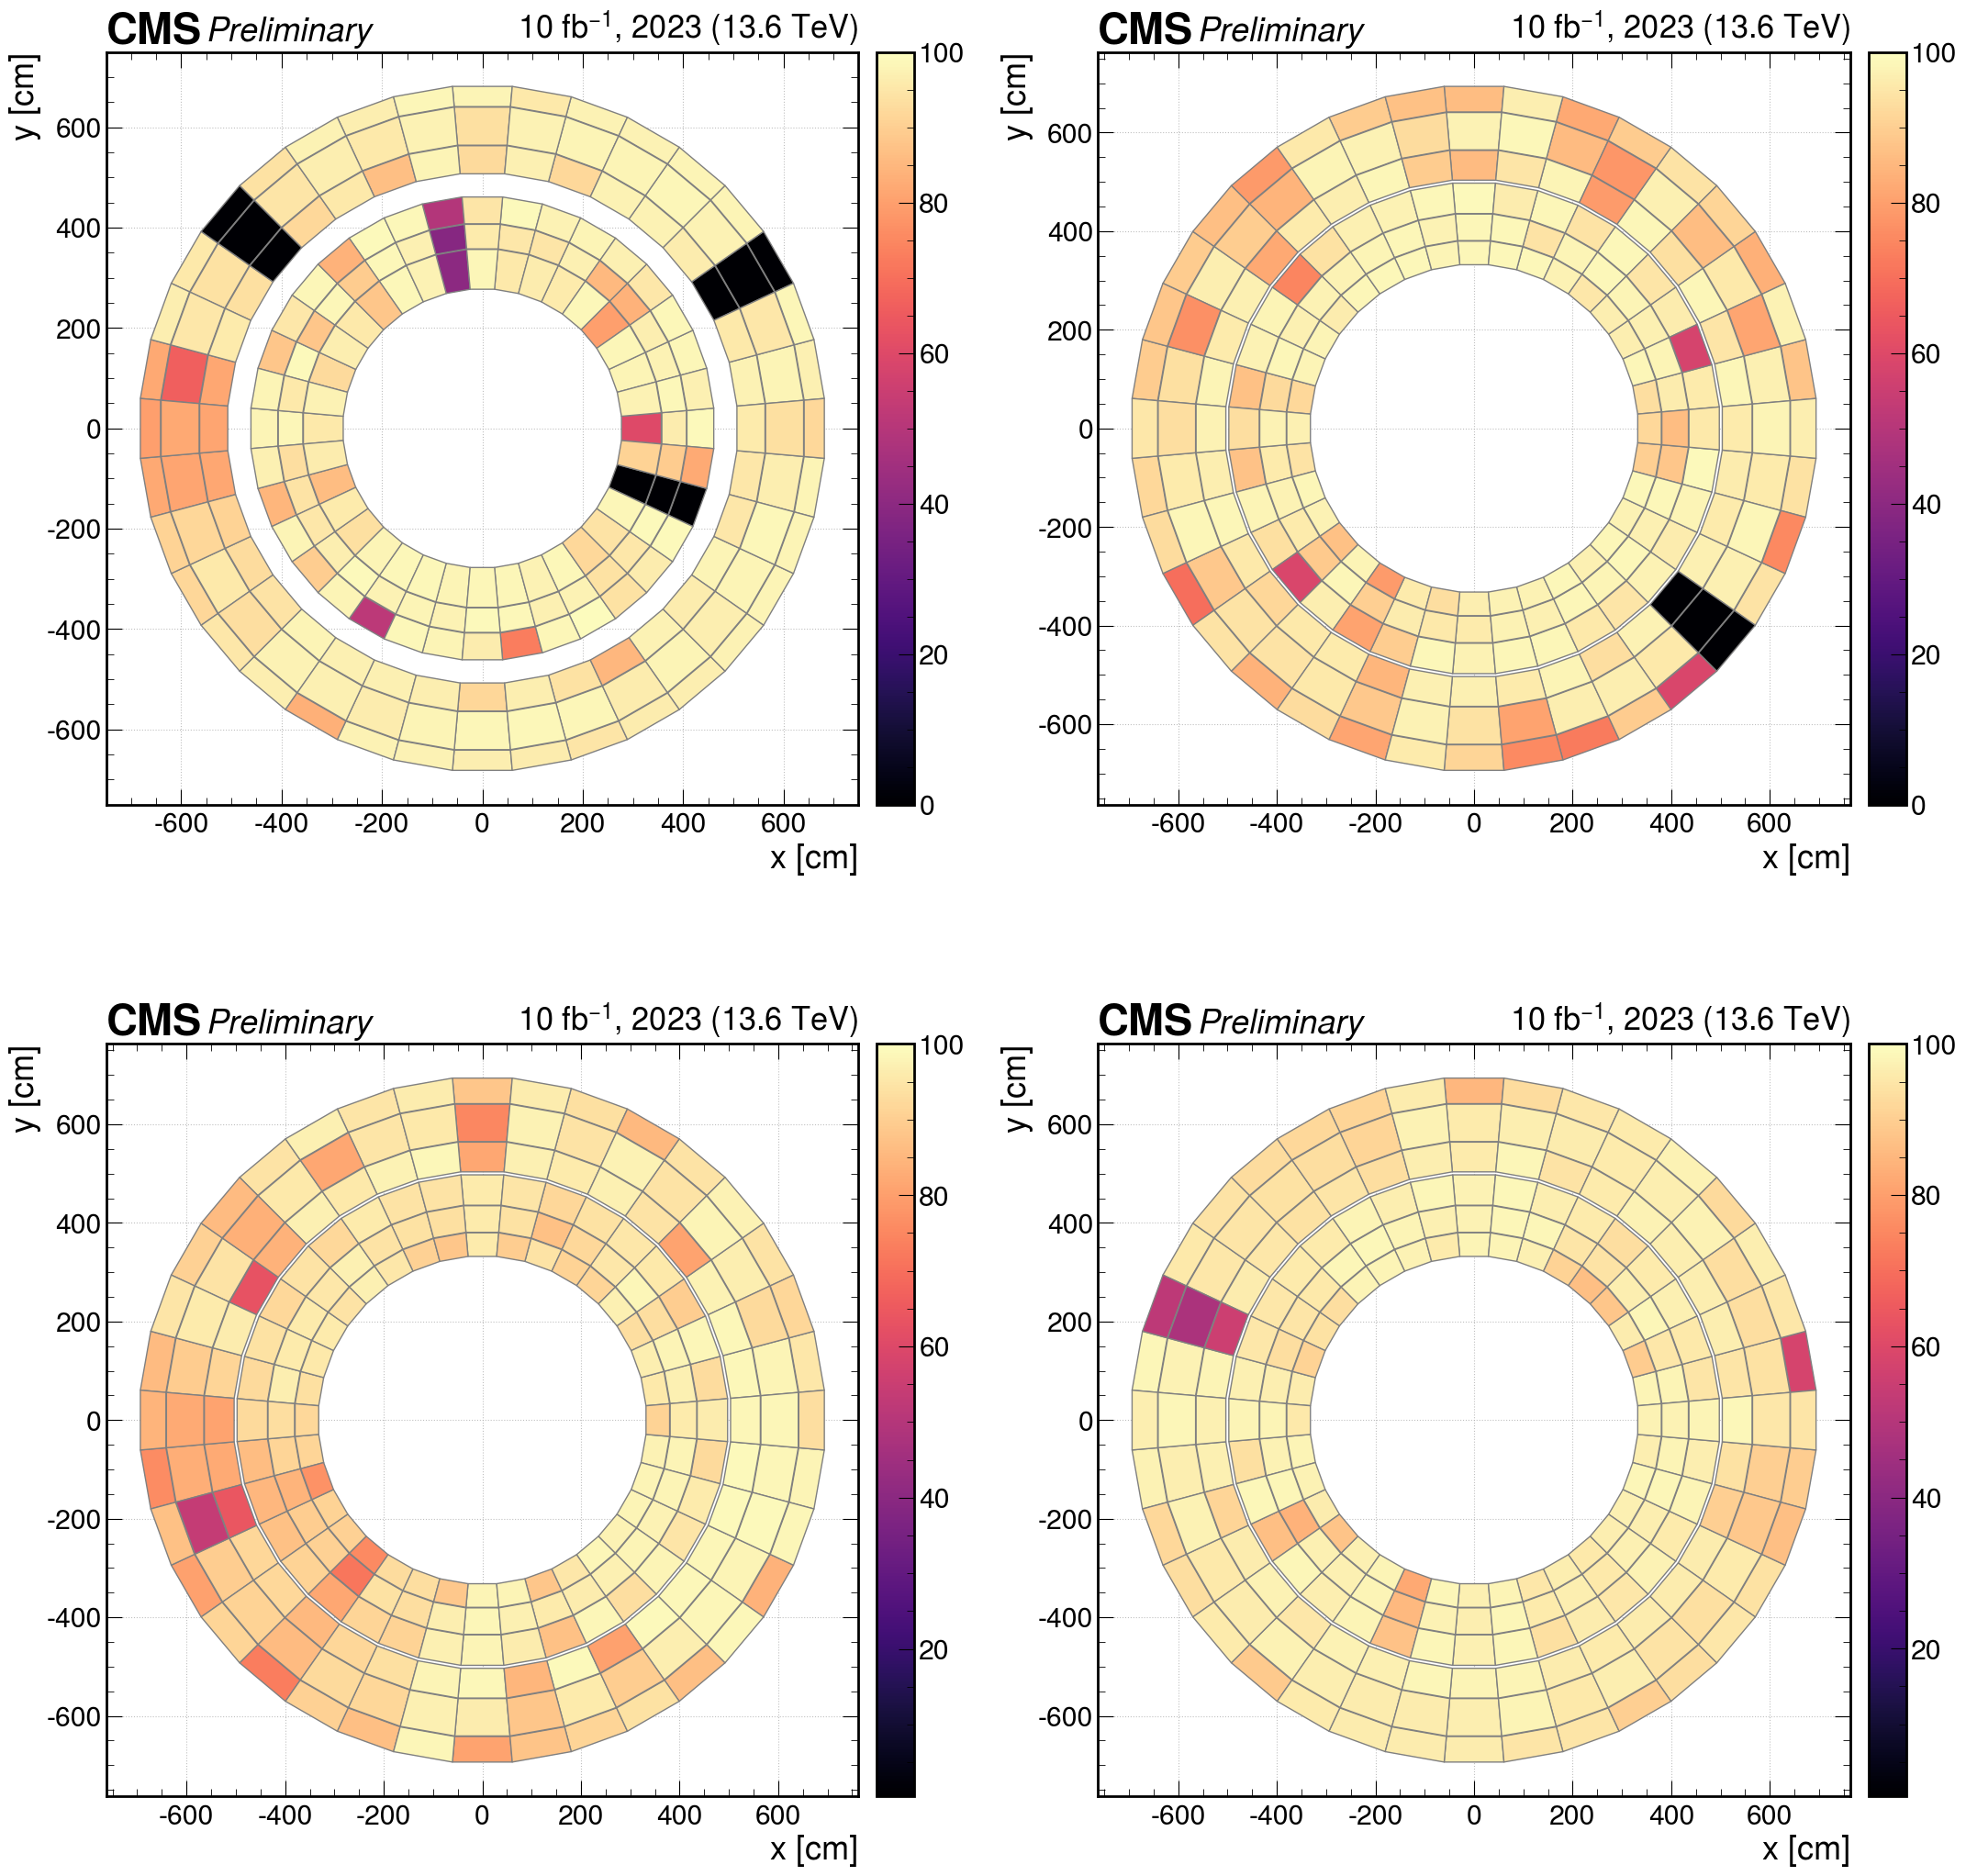

In [214]:
fig, axarr = plt.subplots(figsize=(22, 22), ncols=2, nrows=2)

for ax, key in zip(axarr.ravel(), ['RE+1', 'RE+2', 'RE+3', 'RE+4']):
    patches = [unit.polygon for unit in rpc[key]]
    efficiencies = [eff_data[unit.id.name] for unit in rpc[key]]
    draw_geom(patches, values=efficiencies, ax=ax, vmin=0, vmax=100, xlabel='x [cm]', ylabel='y [cm]')
fig.tight_layout()

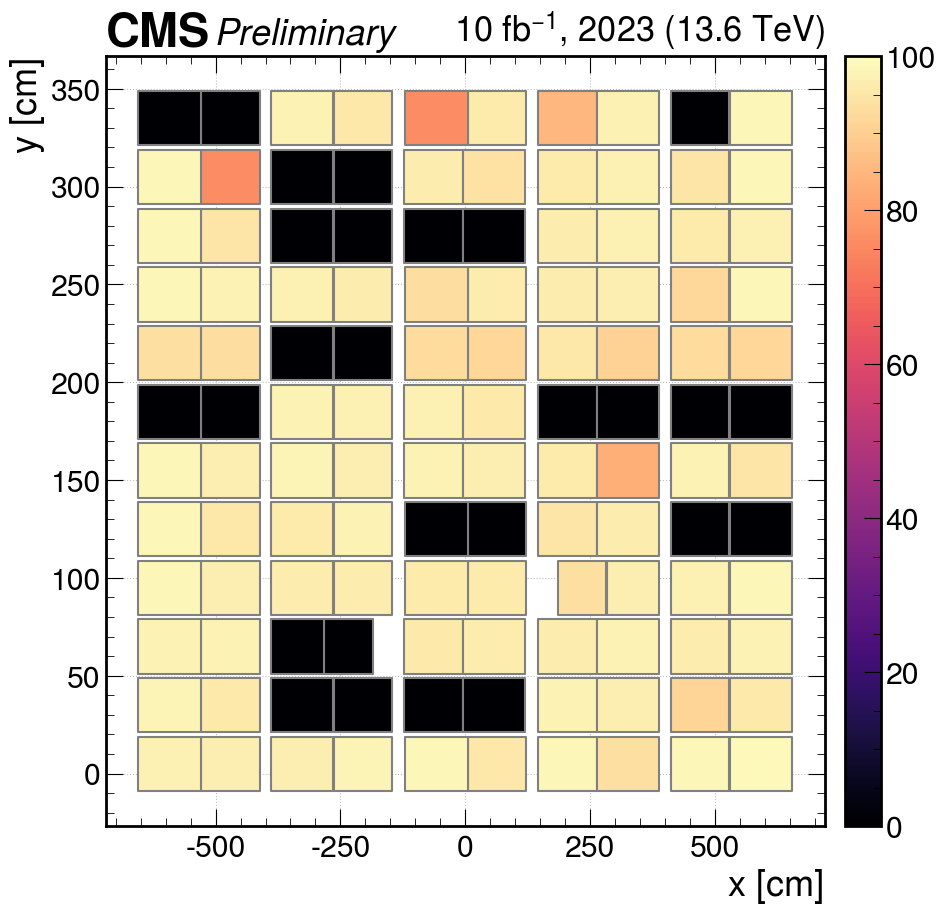

In [194]:
key = 'RB1in'
efficiencies = [eff_data[unit.id.name] for unit in rpc[key]]
patches = [unit.polygon for unit in rpc[key]]

fig, ax = plt.subplots()
draw_geom(patches, efficiencies, ax=ax)